# Kaggle Competition - Image Transformations

#### Logging onto instance in ubuntu
- `cd /mnt/c/Users/drjor`
- `ssh -i "Downloads/homework5.pem" ubuntu@ec2-52-55-226-45.compute-1.amazonaws.com`
    - The above is also provided by the "connect" button on AWS

#### Install some packages prior to being able to use AWS
- `sudo pip install scikit-learn`
- `sudo pip3 install sklearn`
- `wget https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh`

#### Running jupyter notebook on EC2
- `jupyter notebook` in ubuntu command line  
- open another ubuntu terminal local on machine and run the following command when in the directory with the permission key (C:\Users\drjor\Downloads):
    - `ssh -i homework5.pem -NL 8157:localhost:8888 ubuntu@ec2-52-55-226-45.compute-1.amazonaws.com`
    - http://localhost:8157

#### Transfer files from local machine to EC2
Assumes that I am in home directory of C:\Users\drjor

- `scp -i "Downloads/homework5.pem" "OneDrive/UW MSDS/2017-2-Spring Quarter/DATA 558/Kaggle Competition/train.tgz" ubuntu@ec2-52-55-226-45.compute-1.amazonaws.com:~/`

- `scp -i "Downloads/homework5.pem" "OneDrive/UW MSDS/2017-2-Spring Quarter/DATA 558/Kaggle Competition/test.tgz" ubuntu@ec2-52-55-226-45.compute-1.amazonaws.com:~/`

- `scp -i "Downloads/homework5.pem" "OneDrive/UW MSDS/2017-2-Spring Quarter/DATA 558/Kaggle Competition/train_images.csv" ubuntu@ec2-52-55-226-45.compute-1.amazonaws.com:~/`

- `scp -i "Downloads/homework5.pem" "OneDrive/UW MSDS/2017-2-Spring Quarter/DATA 558/Kaggle Competition/train_labels.csv" ubuntu@ec2-52-55-226-45.compute-1.amazonaws.com:~/`

- `scp -i "Downloads/homework5.pem" "OneDrive/UW MSDS/2017-2-Spring Quarter/DATA 558/Kaggle Competition/test_images.csv" ubuntu@ec2-52-55-226-45.compute-1.amazonaws.com:~/`

#### Unpack tgz files in ubuntu
- `mkdir images`
- `tar -xvzf train.tgz -C /home/ubuntu/images`
- `tar -xvzf test.tgz -C /home/ubuntu/images`

#### Install Inception-v3
- `cd src/tensorflow/tensorflow/models/image/imagenet`
- `python classify_image.py --model_dir TUTORIAL_DIR/imagenet`

#### Install AWS CLI
- `pip install --upgrade --user awscli`
- `aws configure`
- AWS Access Key ID [None]: `*****`
- AWS Secret Access Key [None]: `*****`
- Default region name [None]: `us-east-1` (find in EC2 instance 'Availability Zone')
- Default output format [None]: `text`

#### Transfer files from EC2 to S3
- `aws s3 cp features s3://stat558drjordankaggle/features`
- `aws s3 cp labels s3://stat558drjordankaggle/labels`

#### Transfer files from EC2 to local machine
Assumes that I am in home directory of C:\Users\drjor
- `scp -i "Downloads/homework5.pem" ubuntu@ec2-52-55-226-45.compute-1.amazonaws.com:~/Kaggle_Competition.ipynb "OneDrive/UW MSDS/2017-2-Spring Quarter/DATA 558/Kaggle Competition/"`

In [1]:
import os
import pickle
import re
import requests

import tensorflow as tf
import tensorflow.python.platform
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

from io import BytesIO
from matplotlib.pyplot import imshow
from PIL import Image, ImageOps
from sklearn import cross_validation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
from tensorflow.python.platform import gfile

%matplotlib inline

D:\Program Files\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
image_set = 'rotate30'
'''
train
test
mirror
crop
compress
homography
rotate30
scale
color
crop_to_corner
'''

list_images = []
if image_set == 'test':
    image_paths = pd.read_csv('D:/Dane/UW MSDS/2017-2-Spring Quarter/DATA 558/Kaggle Competition/Raw Data/test_images.csv', delimiter=',').values.tolist()
    for i in range(len(image_paths)):
        list_images.append('D:/Dane/UW MSDS/2017-2-Spring Quarter/DATA 558/Kaggle Competition/Pics/test' + '/' + image_paths[i][0][5:])
else:
    image_paths = pd.read_csv('D:/Dane/UW MSDS/2017-2-Spring Quarter/DATA 558/Kaggle Competition/Raw Data/train_images.csv', delimiter=',').values.tolist()
    for i in range(len(image_paths)):
        list_images.append('D:/Dane/UW MSDS/2017-2-Spring Quarter/DATA 558/Kaggle Competition/Pics/train' + '/' + image_paths[i][0][6:])
    
train_image_labels = pd.read_csv('D:/Dane/UW MSDS/2017-2-Spring Quarter/DATA 558/Kaggle Competition/Raw Data/train_labels.csv', delimiter=',').values.tolist()

model_dir = '/home/ubuntu/src/tensorflow/tensorflow/models/image/imagenet/TUTORIAL_DIR/imagenet/'
images_dir = 'D:/Dane/UW MSDS/2017-2-Spring Quarter/DATA 558/Kaggle Competition/Pics' + '/'

In [10]:
def create_graph():
    with gfile.FastGFile(os.path.join(
            model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

In [11]:
def extract_features(list_images):
    nb_features = 2048
    features = np.empty((len(list_images), nb_features))
    labels = []

    create_graph()

    with tf.Session() as sess:

        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')

        for ind, image in enumerate(list_images):
            if (ind % 100 == 0):
                print('Processing %s...' % (image))
            if not gfile.Exists(image):
                tf.logging.fatal('File does not exist %s', image)

            image_data = gfile.FastGFile(image, 'rb').read()
            predictions = sess.run(next_to_last_tensor, {'DecodeJpeg/contents:0': image_data})
            features[ind, :] = np.squeeze(predictions)
            labels.append(image.split('/')[-2].split('.')[0])

    return features

In [ ]:
features = extract_features(list_images)

In [ ]:
pd.DataFrame(features).to_csv(image_set + '_features.csv')
pd.DataFrame(labels).to_csv('labels.csv')

In [ ]:
pickle.dump(features, open(image_set + '_features', 'wb'))
pickle.dump(labels, open('labels', 'wb'))

In [ ]:
features = pickle.load(open('features'))
labels = pickle.load(open('labels'))

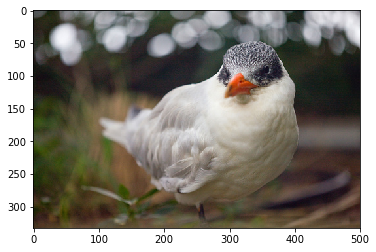

In [23]:
# Read in an image
filepath = list_images[20]

# use 'list_images' and loop through to apply to all images
img = Image.open(filepath)
imshow(np.asarray(img));

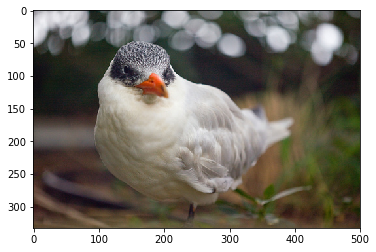

In [24]:
# Mirror the image
def mirror_image(img):
    img_mirror = ImageOps.mirror(img)
    return img_mirror

image_mirror = mirror_image(img)
imshow(np.asarray(image_mirror));

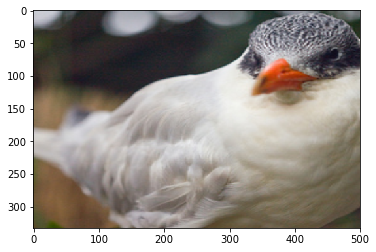

In [25]:
# Crop the image to random coordinates and resize the image
def crop_image(img, i):
    w, h = img.size
    np.random.seed(4 * i)
    x0 = np.random.random() * (w / 4)
    y0 = np.random.random() * (h / 4)
    x1 = w - np.random.random() * (w / 4)
    y1 = h - np.random.random() * (h / 4)

    image_crop = img.crop([int(x0), int(y0), int(x1), int(y1)])
    image_crop = image_crop.resize((w, h), Image.BILINEAR)
    return image_crop

image_crop = crop_image(img, 1)
imshow(np.asarray(image_crop));

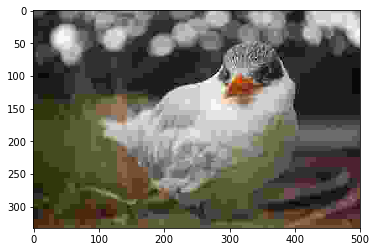

In [26]:
# Compress the image
def compress_image(img):
    buffer = BytesIO()
    img.save(buffer, "jpeg", quality=5)
    buffer.seek(0)
    image_compressed = Image.open(buffer)
    return image_compressed

image_compressed = compress_image(img)
imshow(np.asarray(image_compressed));

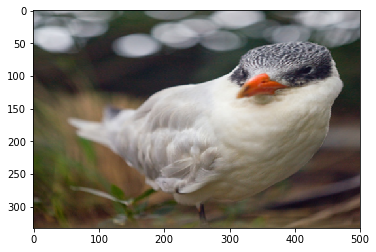

In [27]:
# Homography transformation
def homography_image(img):
    w, h = img.size
    data = (int(0.25 * w), 0, 0, h, w, h, int(0.75 * w), 0)
    image_homo = img.transform((w, h), Image.QUAD, data, Image.BILINEAR)
    return image_homo

image_homo = homography_image(img)
imshow(np.asarray(image_homo));

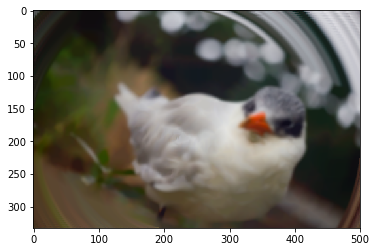

In [29]:
# Rotate the image. In the empty area of the corners use the contents of the original image.
import copy
def rotate_image(image, angle):
    for i in range(abs(angle)):
        white = Image.new('L', image.size, "white")
        wr = white.rotate(np.sign(angle), Image.NEAREST, expand=0)
        im = image.rotate(np.sign(angle), Image.BILINEAR, expand=0)
        image.paste(im, wr)
    return image

img_rotated = rotate_image(copy.deepcopy(img), -30)  # Without copying the image here, it overwrites img!
imshow(np.asarray(img_rotated));

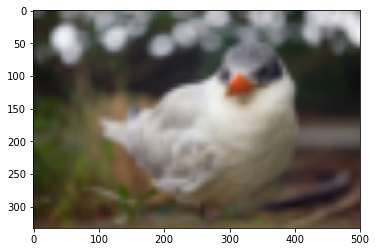

In [30]:
# Scale the image
def scale_image(img):
    scale = 1.5 ** 4.5
    w, h = img.size
    scale_dimensions = int(w / scale), int(h / scale)
    image_scaled = img.resize(scale_dimensions, Image.BILINEAR)
    image_scaled = image_scaled.resize((w, h), Image.BILINEAR)
    return image_scaled

image_scaled = scale_image(img)
imshow(np.asarray(image_scaled));

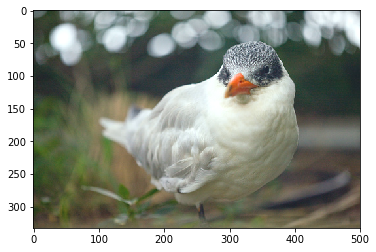

In [31]:
# Colorimetry transformation. 
# The parameter i determines what linear combination of the eigenvalues * eigenvectors to take
def color_image(image, i):
    lcolor = [381688.61379382, 4881.28307136, 2316.10313483]
    pcolor = [[-0.57848371, -0.7915924, 0.19681989],
              [-0.5795621, 0.22908373, -0.78206676],
              [-0.57398987, 0.56648223, 0.59129816]]
    # pre-generated gaussian values
    alphas = [[0.004894, 0.153527, -0.012182],
              [-0.058978, 0.114067, -0.061488],
              [0.002428, -0.003576, -0.125031]]
    p1r = pcolor[0][0]
    p1g = pcolor[1][0]
    p1b = pcolor[2][0]
    p2r = pcolor[0][1]
    p2g = pcolor[1][1]
    p2b = pcolor[2][1]
    p3r = pcolor[0][2]
    p3g = pcolor[1][2]
    p3b = pcolor[2][2]

    l1 = np.sqrt(lcolor[0])
    l2 = np.sqrt(lcolor[1])
    l3 = np.sqrt(lcolor[2])

    if i <= 2:
        alpha = alphas[i]
    else:
        np.random.seed(i * 3)
        alpha = np.random.randn(3, 0, 0.01)
    a1 = alpha[0]
    a2 = alpha[1]
    a3 = alpha[2]

    (dr, dg, db) = (a1 * l1 * p1r + a2 * l2 * p2r + a3 * l3 * p3r,
                    a1 * l1 * p1g + a2 * l2 * p2g + a3 * l3 * p3g,
                    a1 * l1 * p1b + a2 * l2 * p2b + a3 * l3 * p3b)

    table = np.tile(np.arange(256), 3).astype(np.float64)
    table[:256] += dr
    table[256:512] += dg
    table[512:] += db
    image = image.convert("RGB").point(table)
    return image

img_color = color_image(img, 1)
imshow(np.asarray(img_color));

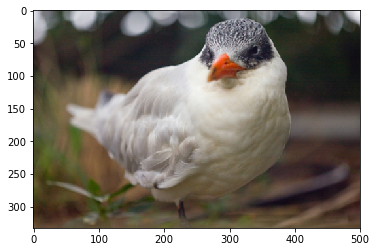

In [32]:
# Crop to a corner. The parameter n tells it which corner to crop to
def crop_corner_image(img, n):
    w, h = img.size
    x0 = 0
    x1 = w
    y0 = 0
    y1 = h

    rat = 256 - 227

    if n == 0:  # center
        x0 = (rat * w) / (2 * 256.0)
        y0 = (rat * h) / (2 * 256.0)
        x1 = w - (rat * w) / (2 * 256.0)
        y1 = h - (rat * h) / (2 * 256.0)
    elif n == 1:
        x0 = (rat * w) / 256.0
        y0 = (rat * h) / 256.0
    elif n == 2:
        x1 = w - (rat * w) / 256.0
        y0 = (rat * h) / 256.0
    elif n == 3:
        x1 = w - (rat * w) / 256.0
        y1 = h - (rat * h) / 256.0
    else:
        assert n == 4
        x0 = (rat * w) / 256.0
        y1 = h - (rat * h) / 256.0

    image_corner = img.crop((int(x0), int(y0), int(x1), int(y1)))
    image_corner = image_corner.resize((w, h), Image.BILINEAR)
    return image_corner


image_corner = crop_corner_image(img, 1)
imshow(np.asarray(image_corner));

In [ ]:
# append all images into lists corresponding to their transformation
images_mirrored = []
images_cropped = []
images_compressed = []
images_homography = []
images_rotated = []
images_scaled = []
images_colorized = []
images_corner_cropped = []

for i in range(len(list_images)):

    filepath = list_images[i]
    img = Image.open(filepath)

    images_mirrored.append(mirror_image(img))
    images_cropped.append(crop_image(img, 1))
    images_compressed.append(compress_image(img))
    images_homography.append(homography_image(img))
    images_rotated.append(rotate_image(img, 30))
    images_scaled.append(scale_image(img))
    images_colorized.append(color_image(img, 1))
    images_corner_cropped.append(crop_corner_image(img, 1))

In [ ]:
# create directories and save images on AWS
for i in range(len(list_images)):
    dirname = list_images[i].split('/')[-2].split(' ')[0]
    filename = list_images[i].split('/')[-1].split(' ')[0]
    
    os.makedirs('/home/ubuntu/images/mirror/' + dirname, exist_ok=True)
    images_mirrored[i].save('/home/ubuntu/images/mirror/' + dirname + '/' + filename)
    
    os.makedirs('/home/ubuntu/images/crop/' + dirname, exist_ok=True)
    images_cropped[i].save('/home/ubuntu/images/crop/' + dirname + '/' + filename)
    
    os.makedirs('/home/ubuntu/images/compress/' + dirname, exist_ok=True)
    images_compressed[i].save('/home/ubuntu/images/compress/' + dirname + '/' + filename)
    
    os.makedirs('/home/ubuntu/images/homography/' + dirname, exist_ok=True)
    images_homography[i].save('/home/ubuntu/images/homography/' + dirname + '/' + filename)
    
    os.makedirs('/home/ubuntu/images/rotate30/' + dirname, exist_ok=True)
    images_rotated[i].save('/home/ubuntu/images/rotate30/' + dirname + '/' + filename)
    
    os.makedirs('/home/ubuntu/images/scale/' + dirname, exist_ok=True)
    images_scaled[i].save('/home/ubuntu/images/scale/' + dirname + '/' + filename)
    
    os.makedirs('/home/ubuntu/images/color/' + dirname, exist_ok=True)
    images_colorized[i].save('/home/ubuntu/images/color/' + dirname + '/' + filename)
    
    os.makedirs('/home/ubuntu/images/crop_to_corner/' + dirname, exist_ok=True)
    images_corner_cropped[i].save('/home/ubuntu/images/crop_to_corner/' + dirname + '/' + filename)